### Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')
import matplotlib.pyplot as plt
from yellowbrick.regressor import ResidualsPlot
import statsmodels.api as sm
from statsmodels.api import OLS

#SKLearn stuff
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
df = pd.read_csv('../../data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,NONE,...,7 Average,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,NO,NONE,...,7 Average,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,NO,NONE,...,6 Low Average,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,NO,NONE,...,7 Average,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,NO,NONE,...,8 Good,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


### Initial Cleaning

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

The column sqft_basement has 454 '?' values. Used  sqft_living and sqft_above to fill in the values. 

In [4]:
df['sqft_basement'] = df['sqft_living'] - df['sqft_above']

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  object 
 9   view           21534 non-null  object 
 10  condition      21597 non-null  object 
 11  grade          21597 non-null  object 
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  int64  
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

#### Drops

Dropping 'id', 'yr_renovated', and 'date'. No use for them and we don't have enough data to use them. 

In [6]:
df = df.drop(['id', 'date', 'yr_renovated'], axis=1) 

#### Outliers?

In [7]:
price_q75, price_q25 = np.percentile(df['price'],[75,25])
intr_qrt = price_q75-price_q25
upper_price = price_q75 + (1.5*intr_qrt)
lower_price = price_q25 - (1.5*intr_qrt)
lower_price, upper_price
df = df[df['price'] <= upper_price]
df = df[df['price'] >= lower_price]

In [8]:
df['sqft_lot'].describe()

count    2.043900e+04
mean     1.458557e+04
std      4.000982e+04
min      5.200000e+02
25%      5.000000e+03
50%      7.500000e+03
75%      1.031650e+04
max      1.651359e+06
Name: sqft_lot, dtype: float64

In [9]:
sqft_lot_q75, sqft_lot_q25 = np.percentile(df['sqft_lot'],[75,25])
intr_qrt = sqft_lot_q75-sqft_lot_q25
upper_sqft_lot = sqft_lot_q75 + (1.5*intr_qrt)
lower_sqft_lot = sqft_lot_q25 - (1.5*intr_qrt)
lower_sqft_lot, upper_sqft_lot
df = df[df['sqft_lot'] <= upper_sqft_lot]
df = df[df['sqft_lot'] >= lower_sqft_lot]

In [10]:
df['grade'].value_counts()

7 Average        8372
8 Good           5297
6 Low Average    1872
9 Better         1866
10 Very Good      513
5 Fair            198
11 Excellent       75
4 Low              20
12 Luxury           1
3 Poor              1
Name: grade, dtype: int64

In [11]:
df = df[df['grade'] != '3 Poor']
df = df[df['grade'] != '12 Luxury']

In [12]:
df['view'].value_counts()

NONE         16871
AVERAGE        681
GOOD           257
FAIR           246
EXCELLENT      104
Name: view, dtype: int64

### Split

Using price as a dependent variable. Assuming our stockholder is a real estate/brokerage company, TBD, who gets a commission on each sale or purchase.

In [13]:
y = df["price"]
X = df.drop("price", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.33)

### Categorical Columns

The column 'waterfront' is a binomial categorical variable. The columns 'bathrooms', 'view', 'zipcode', 'condition', and 'grade' are categorical variables. They will need to be converted into a format that can be modeled. 

Need to drop columns for each. Should make a function to do encoding.

#### Waterfront

The column contains Yes and No values. I'm assuming NAs are Nos so I will be filling them in as such.

In [14]:
X_train['waterfront'].fillna('NO', inplace=True)
X_test['waterfront'].fillna('NO', inplace=True)

In [15]:
waterfront_train = X_train[['waterfront']]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_train)
encoder_waterfront.categories_[0]
waterfront_encoded_train = encoder_waterfront.transform(waterfront_train)
waterfront_encoded_train = waterfront_encoded_train.flatten()
X_train["waterfront"] = waterfront_encoded_train

In [16]:
waterfront_test = X_test[['waterfront']]
encoder_waterfront = OrdinalEncoder()
encoder_waterfront.fit(waterfront_test)
encoder_waterfront.categories_[0]
waterfront_encoded_test = encoder_waterfront.transform(waterfront_test)
waterfront_encoded_test = waterfront_encoded_test.flatten()
X_test["waterfront"] = waterfront_encoded_test

#### View 

The column 'view' has 5 categories; NONE, AVERAGE, GOOD, FAIR, and EXCELLENT. I'm assuming NAs are NONE so I will be filling them in as such.

Created a OneHotEncoder function for the categorical variables. 

In [17]:
X_train['view'].fillna("NONE", inplace=True)
X_test['view'].fillna("NONE", inplace=True)

In [18]:
X_train

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,lat,long,sqft_living15,sqft_lot15
8374,3,1.75,1850,15170,1.0,0.0,NONE,Average,7 Average,1850,0,1965,98045,47.4991,-121.774,1160,14175
2713,3,1.00,1810,12375,2.0,0.0,NONE,Average,7 Average,1810,0,1970,98072,47.7427,-122.172,1420,9357
14757,2,1.75,2320,5500,1.5,0.0,AVERAGE,Average,8 Good,1720,600,1925,98144,47.5860,-122.292,2380,5000
16240,3,1.75,1470,8350,1.0,0.0,NONE,Average,7 Average,1470,0,1990,98001,47.2587,-122.253,1590,8182
5790,4,1.75,1650,7800,1.0,0.0,NONE,Average,8 Good,1650,0,1968,98058,47.4507,-122.139,1750,10400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13470,2,2.50,1170,1811,2.0,0.0,NONE,Average,8 Good,1170,0,2001,98122,47.6132,-122.297,1250,3146
14277,4,2.75,2720,6427,1.0,0.0,NONE,Average,8 Good,1650,1070,2008,98146,47.4931,-122.354,2720,8484
6444,3,2.25,1610,5159,2.0,0.0,NONE,Average,7 Average,1610,0,1985,98029,47.5675,-122.019,1610,5210
1022,3,1.75,1260,7128,1.0,0.0,NONE,Good,7 Average,1260,0,1969,98034,47.7263,-122.205,1330,7326


In [19]:
#ohe = OneHotEncoder(sparse=False, handle_unknown="ignore")

In [20]:
def ohe(df, df2, column):    
    for col in column:
        train = df[[col]]
        ohe = OneHotEncoder(drop="first", sparse=False, handle_unknown="error")
        ohe.fit(train)
        encoded_train = ohe.transform(train)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_train = pd.DataFrame(encoded_train,
                                     columns=col_names, index=df.index)
        df = pd.concat([df, encoded_train], axis=1)
        
        test = df2[[col]]
        encoded_test = ohe.transform(test)
        col_names = [f"{col}_{f}" for f in ohe.get_feature_names()]
        encoded_test = pd.DataFrame(encoded_test, 
                                    columns=col_names, index=df2.index)
        df2 = pd.concat([df2, encoded_test], axis=1)
    return df, df2, encoded_train.columns.tolist()

In [21]:
X_train, X_test, encoded_view = ohe(X_train, X_test, ['view'])

In [22]:
# Change view rating to a numeric value for comparitive purposes.
X_train['view'] = X_train['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

In [23]:
X_test['view'] = X_test['view'].map({'EXCELLENT':5,
                             'GOOD':4,
                             'AVERAGE':3,
                             'FAIR':2,
                             'NONE':1})

#### Condition 

In [24]:
X_train, X_test, encoded_condition = ohe(X_train, X_test, ['condition'])

In [25]:
# Change condition rating to a numeric value for comparitive purposes.
X_train['condition'] = X_train['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

In [26]:
X_test['condition'] = X_test['condition'].map({'Very Good':5,
                                       'Good':4,
                                       'Average':3,
                                       'Fair':2,
                                       'Poor':1})

#### Grade 

In [27]:
X_train, X_test, encoded_grade = ohe(X_train, X_test, ['grade'])

#### Zipcode 

In [28]:
X_train, X_test, encoded_zipcode = ohe(X_train, X_test, ['zipcode'])

### Models

In [29]:
df.corr().price.abs().sort_values(ascending=False)

price            1.000000
sqft_living      0.598950
sqft_living15    0.536436
sqft_above       0.492494
lat              0.450124
bathrooms        0.429231
bedrooms         0.285599
floors           0.262948
sqft_basement    0.250868
long             0.034643
sqft_lot15       0.024667
yr_built         0.024396
sqft_lot         0.005264
zipcode          0.003271
Name: price, dtype: float64

#### Base Model 

In [30]:
cols = ['sqft_living']
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [31]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.34824223805415255
Test Score: 0.3794062431716766


#### Model 1

Using columns sqft_living, bedrooms, sqft_living15, and the columns created from encoding 'grade'.

In [32]:
cols = ['sqft_living', 'bedrooms', 'sqft_living15'] +  encoded_grade
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

Make a function for this ^

In [33]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.4359645551113732
Test Score: 0.4505157635254219


Make a function for this ^

#### Model 2

Using columns sqft_living, 'sqft_living15', 'bathrooms', and the columns created from encoding 'zipcode'.

Note the difference between entering the encoding for 'zipcode' and actually entering 'zipcode'. The encoding gives us a higher R2 value, however, it also gives you a much larger RSME Error.

In [34]:
cols = ['sqft_living', 'bathrooms', 'sqft_living15'] +  encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)


In [35]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.7968963229036872
Test Score: 0.8061309678056533


In [36]:
print("Training Metrics:")
print(f"R2: {r2_score(y_train, train_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")

Training Metrics:
R2: 0.797
Mean Absolute Error: 67216.652
Mean Squared Error: 8455770111.066
Root Mean Squared Error: 91955.261


In [37]:
print("Testing Metrics:")
print(f"R2: {r2_score(y_test, test_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

Testing Metrics:
R2: 0.806
Mean Absolute Error: 66025.012
Mean Squared Error: 8084028851.479
Root Mean Squared Error: 89911.228


Make a function for these ^

Compared to using unencoded zipcode 

In [72]:
cols = ['sqft_living', 'bathrooms', 'sqft_living15', 'zipcode']
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [73]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.396827401025433
Test Score: 0.4123257518266428


In [74]:
print("Training Metrics:")
print(f"R2: {r2_score(y_train, train_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")

Training Metrics:
R2: 0.397
Mean Absolute Error: 127320.937
Mean Squared Error: 25111750349.081
Root Mean Squared Error: 158466.875


In [75]:
print("Testing Metrics:")
print(f"R2: {r2_score(y_test, test_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

Testing Metrics:
R2: 0.412
Mean Absolute Error: 125692.644
Mean Squared Error: 24505077080.811
Root Mean Squared Error: 156540.976


#### Model 3

Using columns  'sqft_living', 'bedrooms', 'sqft_living15', and the columns created from encoding 'zipcode'.

In [42]:
cols = ['sqft_living', 'bedrooms', 'sqft_living15'] +  encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [43]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.7974892468238525
Test Score: 0.8063772504777029


In [44]:
print("Training Metrics:")
print(f"R2: {r2_score(y, train_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y, train_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y, train_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y, train_preds, squared=False):.3f}")

Training Metrics:
R2: 0.797
Mean Absolute Error: 67123.477
Mean Squared Error: 8431085041.677
Root Mean Squared Error: 91820.940


In [45]:
print("Testing Metrics:")
print(f"R2: {r2_score(y_test, test_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

Testing Metrics:
R2: 0.806
Mean Absolute Error: 65945.215
Mean Squared Error: 8073759257.600
Root Mean Squared Error: 89854.100


#### Model 4

Using columns 'sqft_living', 'bedrooms', and the columns created from encoding 'zipcode' and 'condition'.

In [46]:
cols = ['sqft_living', 'bedrooms'] +  encoded_zipcode + encoded_condition
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [47]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.7877433514386127
Test Score: 0.7985399713664608


In [48]:
print("Training Metrics:")
print(f"R2: {r2_score(y_train, train_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")

Training Metrics:
R2: 0.788
Mean Absolute Error: 68291.244
Mean Squared Error: 8836833731.618
Root Mean Squared Error: 94004.435


In [49]:
print("Testing Metrics:")
print(f"R2: {r2_score(y_test, test_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

Testing Metrics:
R2: 0.799
Mean Absolute Error: 66736.689
Mean Squared Error: 8400561273.039
Root Mean Squared Error: 91654.576


#### Model 5

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'condition', 'view', and the columns created from encoding 'zipcode'. 

In [50]:
cols = ['sqft_living', 'bedrooms', 'bathrooms', 'condition', 'view'] +  encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [51]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.8046052210878121
Test Score: 0.8070894715488701


In [52]:
print("Training Metrics:")
print(f"R2: {r2_score(y_train, train_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")

Training Metrics:
R2: 0.805
Mean Absolute Error: 66109.055
Mean Squared Error: 8134827271.495
Root Mean Squared Error: 90193.277


In [53]:
print("Testing Metrics:")
print(f"R2: {r2_score(y_test, test_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

Testing Metrics:
R2: 0.807
Mean Absolute Error: 65656.549
Mean Squared Error: 8044060777.018
Root Mean Squared Error: 89688.688


##### model 5.0

Compared to encoded view and condition.

In [54]:
cols = ['sqft_living', 'bedrooms', 'bathrooms'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [55]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.8060847264209755
Test Score: 0.8085306219356758


In [56]:
print("Training Metrics:")
print(f"R2: {r2_score(y_train, train_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")

Training Metrics:
R2: 0.806
Mean Absolute Error: 65908.267
Mean Squared Error: 8073231355.782
Root Mean Squared Error: 89851.162


In [57]:
print("Testing Metrics:")
print(f"R2: {r2_score(y_test, test_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

Testing Metrics:
R2: 0.809
Mean Absolute Error: 65306.152
Mean Squared Error: 7983967108.760
Root Mean Squared Error: 89353.048


#### Model 6

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'condition', 'view', and 'zipcode'. 

In [78]:
cols = ['sqft_living', 'bedrooms', 'bathrooms', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [79]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.8063258622475814
Test Score: 0.8086167102339586


In [80]:
print("Training Metrics:")
print(f"R2: {r2_score(y_train, train_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")

Training Metrics:
R2: 0.806
Mean Absolute Error: 65876.655
Mean Squared Error: 8063192201.669
Root Mean Squared Error: 89795.279


In [81]:
print("Testing Metrics:")
print(f"R2: {r2_score(y_test, test_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

Testing Metrics:
R2: 0.809
Mean Absolute Error: 65318.926
Mean Squared Error: 7980377364.285
Root Mean Squared Error: 89332.958


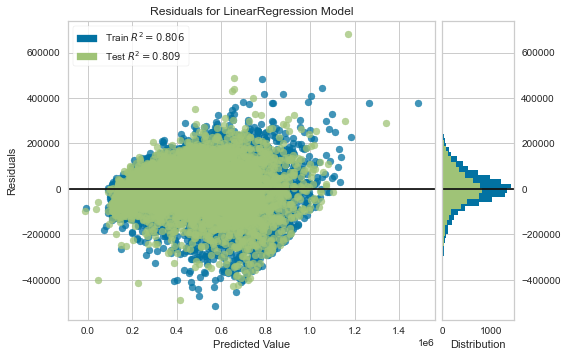

In [82]:
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

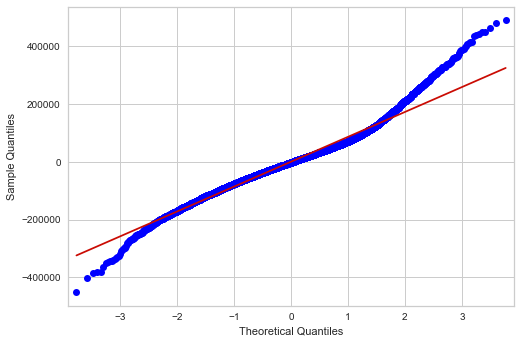

In [91]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');

#### Model 7

Using columns 'sqft_living', 'bedrooms', 'bathrooms', 'yr_built' and the columns created from encoding 'condition', 'view', and 'zipcode'. 

In [84]:
cols = ['sqft_living', 'sqft_living15', 'bedrooms', 'bathrooms', 'yr_built'] + encoded_condition + encoded_view + encoded_zipcode
y = y_train
x = X_train.filter(cols, axis=1)

y2 = y_test
x2 = X_test.filter(cols, axis=1)

In [85]:
scaler = StandardScaler()
scaler.fit(x)
X_train_scaled = scaler.transform(x)
X_test_scaled = scaler.transform(x2)

lr = LinearRegression()
lr.fit(X_train_scaled,y_train)

train_preds = lr.predict(X_train_scaled)
test_preds = lr.predict(X_test_scaled)

print('Training Score:',r2_score(y_train,train_preds))
print('Test Score:',r2_score(y_test,test_preds))

Training Score: 0.8169469536267172
Test Score: 0.8178064938492347


In [86]:
print("Training Metrics:")
print(f"R2: {r2_score(y_train, train_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_train, train_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_train, train_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_train, train_preds, squared=False):.3f}")

Training Metrics:
R2: 0.817
Mean Absolute Error: 64075.721
Mean Squared Error: 7621006672.020
Root Mean Squared Error: 87298.377


In [87]:
print("Testing Metrics:")
print(f"R2: {r2_score(y_test, test_preds):.3f}")
print(f"Mean Absolute Error: {mean_absolute_error(y_test, test_preds):.3f}")
print(f"Mean Squared Error: {mean_squared_error(y_test, test_preds):.3f}")
print(f"Root Mean Squared Error: {mean_squared_error(y_test, test_preds, squared=False):.3f}")

Testing Metrics:
R2: 0.818
Mean Absolute Error: 63737.903
Mean Squared Error: 7597178072.249
Root Mean Squared Error: 87161.793


I want to take a look at the interaction between sqft_living and sqft_living15.

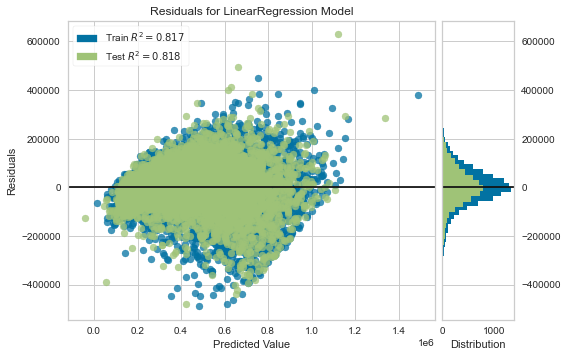

In [88]:
visualizer = ResidualsPlot(lr)

visualizer.fit(X_train_scaled, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_scaled, y_test)  # Evaluate the model on the test data
visualizer.show()  
plt.show()

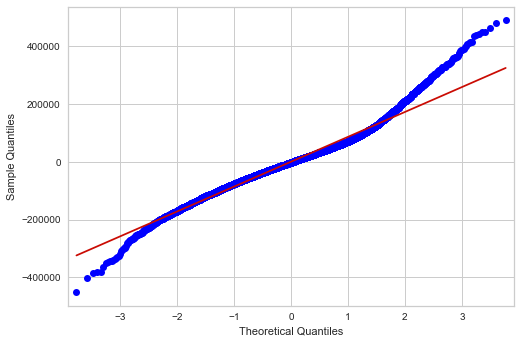

In [90]:
train_residuals = y_train - train_preds
test_residuals = y_test - test_preds
sm.qqplot(train_residuals, line = 'r');